### 1. Load and visualize data

In [1]:
import os
import cv2
import matplotlib.pyplot as plt
import numpy as np

In [2]:
IMAGE_DIR= 'frames'
MASK_DIR = 'masks'

In [3]:
image_filenames = sorted(os.listdir(IMAGE_DIR))
mask_filenames = sorted(os.listdir(MASK_DIR))

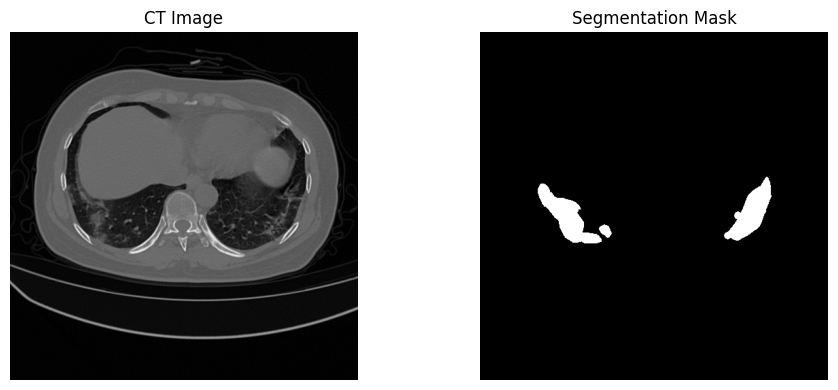

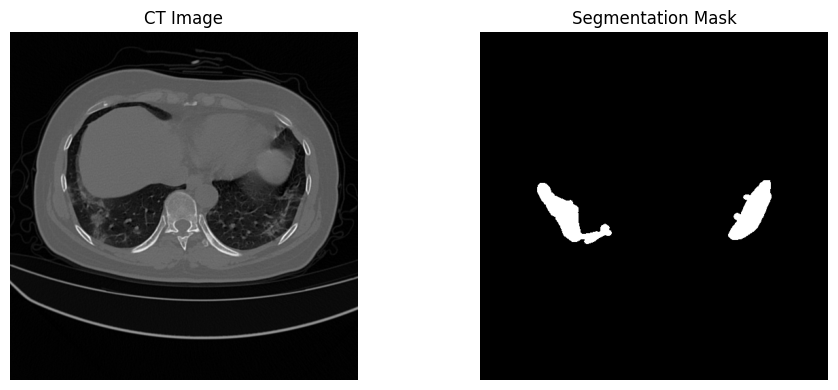

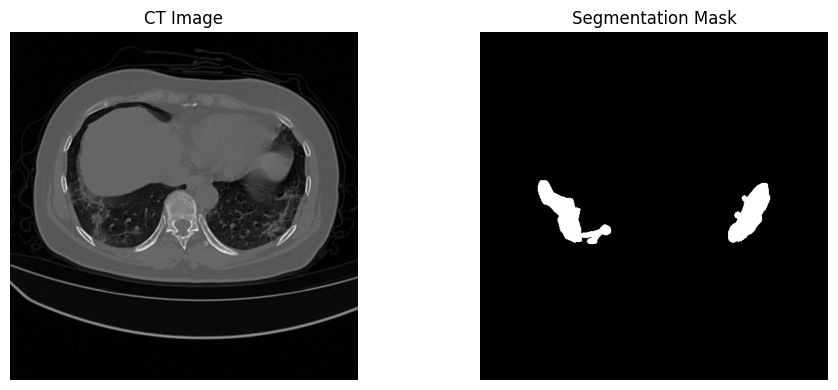

In [4]:
def visualize_sample(index):
    img_path = os.path.join(IMAGE_DIR, image_filenames[index])
    mask_path = os.path.join(MASK_DIR, mask_filenames[index])

    image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(image, cmap='gray')
    plt.title("CT Image")
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(mask, cmap='gray')
    plt.title("Segmentation Mask")
    plt.axis('off')

    plt.tight_layout()
    plt.show()

for i in range(3):
    visualize_sample(i)

### 2. Preprocessing

In [5]:
from sklearn.model_selection import train_test_split

In [6]:
import os
import cv2

In [7]:
IMAGE_DIR = "frames"
MASK_DIR = "masks"

IMG_HEIGHT, IMG_WIDTH = 128, 128

images = []
masks = []

image_filenames = sorted(os.listdir(IMAGE_DIR))
mask_filenames = sorted(os.listdir(MASK_DIR))

for img_file, mask_file in zip(image_filenames, mask_filenames):
    img_path = os.path.join(IMAGE_DIR, img_file)
    mask_path = os.path.join(MASK_DIR, mask_file)

    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

    img = cv2.resize(img, (IMG_WIDTH, IMG_HEIGHT))
    mask = cv2.resize(mask, (IMG_WIDTH, IMG_HEIGHT))

    img = img/255.0
    mask = mask/255.0

    img = np.expand_dims(img, axis=-1)
    mask = np.expand_dims(mask, axis=-1)

    images.append(img)
    masks.append(mask)


In [8]:
images = np.array(images)
masks = np.array(masks)

X_train, X_val, y_train, y_val = train_test_split(
    images, masks, test_size=0.2, random_state=42
)

print("Training data shape:", X_train.shape)
print("Validation data shape:", X_val.shape)

Training data shape: (2183, 128, 128, 1)
Validation data shape: (546, 128, 128, 1)


### 3. U-net Model

In [9]:
from tensorflow.keras import Model, Input
from tensorflow.keras.layers import Conv2D, MaxPooling2D, UpSampling2D, concatenate

In [11]:
def unet_model(input_size=(128, 128, 1)):
    inputs= Input(input_size)

    #Encoder
    c1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    c1 = Conv2D(64, 3, activation='relu', padding='same')(c1)
    p1 = MaxPooling2D()(c1)

    c2 = Conv2D(128, 3, activation='relu', padding='same')(p1)
    c2 = Conv2D(128, 3, activation='relu', padding='same')(c2)
    p2 = MaxPooling2D()(c2)

    c3 = Conv2D(256, 3, activation='relu', padding='same')(p2)
    c3 = Conv2D(256, 3, activation='relu', padding='same')(c3)
    p3 = MaxPooling2D()(c3)

    #Bottleneck
    c4 = Conv2D(512, 3, activation='relu', padding='same')(p3)
    c4 = Conv2D(512, 3, activation='relu', padding='same')(c4)

    #Decoder
    u5 = UpSampling2D()(c4)
    u5 = concatenate([u5, c3])
    c5 = Conv2D(256, 3, activation='relu', padding='same')(u5)
    c5 = Conv2D(256, 3, activation='relu', padding='same')(c5)

    u6 = UpSampling2D()(c5)
    u6 = concatenate([u6, c2])
    c6 = Conv2D(128, 3, activation='relu', padding='same')(u6)
    c6 = Conv2D(128, 3, activation='relu', padding='same')(c6)

    u7 = UpSampling2D()(c6)
    u7 = concatenate([u7, c1])
    c7 = Conv2D(64, 3, activation='relu', padding='same')(u7)
    c7 = Conv2D(64, 3, activation='relu', padding='same')(c7)

    #output
    outputs = Conv2D(1, 1, activation='sigmoid')(c7)

    model = Model(inputs=inputs, outputs=outputs)
    return model



### 3.1 Dice Loss

In [23]:
import tensorflow.keras.backend as K

def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f*y_pred_f)
    return 1 - (2. *intersection+smooth)/(K.sum(y_true_f)+K.sum(y_pred_f)+smooth)


In [25]:
from tensorflow.keras.losses import BinaryCrossentropy

bce = BinaryCrossentropy()

def combined_loss(y_true, y_pred):
    return 0.5*bce(y_true, y_pred)+0.5*dice_loss(y_true, y_pred)

In [27]:
model.compile(
    optimizer=Adam(1e-4),
    loss=dice_loss,
    metrics=['accuracy', MeanIoU(num_classes=2)]
)

### 4. Train the model

In [12]:
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.metrics import MeanIoU
from tensorflow.keras.callbacks import ModelCheckpoint

In [26]:
model= unet_model(input_size=(128, 128, 1))

In [14]:
model.compile(optimizer=Adam(learning_rate=1e-4),
              loss=BinaryCrossentropy(),
              metrics=['accuracy', MeanIoU(num_classes=2)])

checkpoint = ModelCheckpoint("best_unet.h5", save_best_only=True, verbose=1)

history = model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    batch_size=16,
    epochs=20,
    callbacks=[checkpoint]
)

Epoch 1/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9696 - loss: 0.2635 - mean_io_u: 0.4930
Epoch 1: val_loss improved from inf to 0.06457, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 654s 5s/step - accuracy: 0.9697 - loss: 0.2626 - mean_io_u: 0.4930 - val_accuracy: 0.9828 - val_loss: 0.0646 - val_mean_io_u: 0.4928
Epoch 2/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9829 - loss: 0.0611 - mean_io_u: 0.4928
Epoch 2: val_loss improved from 0.06457 to 0.05708, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 654s 5s/step - accuracy: 0.9829 - loss: 0.0611 - mean_io_u: 0.4928 - val_accuracy: 0.9828 - val_loss: 0.0571 - val_mean_io_u: 0.4928
Epoch 3/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9844 - loss: 0.0474 - mean_io_u: 0.4935
Epoch 3: val_loss improved from 0.05708 to 0.04541, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 657s 5s/step - accuracy: 0.9844 - loss: 0.0474 - mean_io_u: 0.4935 - val_accuracy: 0.9828 - val_loss: 0.0454 - val_mean_io_u: 0.4928
Epoch 4/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9827 - loss: 0.0439 - mean_io_u: 0.4925
Epoch 4: val_loss improved from 0.04541 to 0.03707, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 657s 5s/step - accuracy: 0.9827 - loss: 0.0438 - mean_io_u: 0.4925 - val_accuracy: 0.9862 - val_loss: 0.0371 - val_mean_io_u: 0.4928
Epoch 5/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9862 - loss: 0.0356 - mean_io_u: 0.4927
Epoch 5: val_loss improved from 0.03707 to 0.03204, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 653s 5s/step - accuracy: 0.9862 - loss: 0.0356 - mean_io_u: 0.4927 - val_accuracy: 0.9874 - val_loss: 0.0320 - val_mean_io_u: 0.4928
Epoch 6/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9884 - loss: 0.0293 - mean_io_u: 0.4931
Epoch 6: val_loss did not improve from 0.03204
137/137 ━━━━━━━━━━━━━━━━━━━━ 652s 5s/step - accuracy: 0.9884 - loss: 0.0293 - mean_io_u: 0.4931 - val_accuracy: 0.9856 - val_loss: 0.0357 - val_mean_io_u: 0.4928
Epoch 7/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9900 - loss: 0.0255 - mean_io_u: 0.4935
Epoch 7: val_loss improved from 0.03204 to 0.02449, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 675s 5s/step - accuracy: 0.9900 - loss: 0.0255 - mean_io_u: 0.4935 - val_accuracy: 0.9898 - val_loss: 0.0245 - val_mean_io_u: 0.4928
Epoch 8/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9903 - loss: 0.0228 - mean_io_u: 0.4930
Epoch 8: val_loss improved from 0.02449 to 0.02353, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 666s 5s/step - accuracy: 0.9903 - loss: 0.0228 - mean_io_u: 0.4930 - val_accuracy: 0.9900 - val_loss: 0.0235 - val_mean_io_u: 0.4928
Epoch 9/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9920 - loss: 0.0184 - mean_io_u: 0.4937
Epoch 9: val_loss improved from 0.02353 to 0.02308, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 664s 5s/step - accuracy: 0.9919 - loss: 0.0184 - mean_io_u: 0.4937 - val_accuracy: 0.9900 - val_loss: 0.0231 - val_mean_io_u: 0.4928
Epoch 10/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9916 - loss: 0.0188 - mean_io_u: 0.4930
Epoch 10: val_loss improved from 0.02308 to 0.02126, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 659s 5s/step - accuracy: 0.9916 - loss: 0.0188 - mean_io_u: 0.4930 - val_accuracy: 0.9905 - val_loss: 0.0213 - val_mean_io_u: 0.4928
Epoch 11/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9924 - loss: 0.0161 - mean_io_u: 0.4934
Epoch 11: val_loss improved from 0.02126 to 0.01784, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 654s 5s/step - accuracy: 0.9924 - loss: 0.0161 - mean_io_u: 0.4934 - val_accuracy: 0.9918 - val_loss: 0.0178 - val_mean_io_u: 0.4928
Epoch 12/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9927 - loss: 0.0155 - mean_io_u: 0.4928
Epoch 12: val_loss did not improve from 0.01784
137/137 ━━━━━━━━━━━━━━━━━━━━ 649s 5s/step - accuracy: 0.9927 - loss: 0.0155 - mean_io_u: 0.4928 - val_accuracy: 0.9917 - val_loss: 0.0185 - val_mean_io_u: 0.4928
Epoch 13/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9932 - loss: 0.0141 - mean_io_u: 0.4933
Epoch 13: val_loss did not improve from 0.01784
137/137 ━━━━━━━━━━━━━━━━━━━━ 650s 5s/step - accuracy: 0.9932 - loss: 0.0141 - mean_io_u: 0.4933 - val_accuracy: 0.9898 - val_loss: 0.0242 - val_mean_io_u: 0.4928
Epoch 14/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9914 - loss: 0.0195 - mean_io_u: 0.4932
Epoch 14: val_loss improved from 0.01784 to 0.01724, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 642s 5s/step - accuracy: 0.9914 - loss: 0.0195 - mean_io_u: 0.4932 - val_accuracy: 0.9920 - val_loss: 0.0172 - val_mean_io_u: 0.4928
Epoch 15/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9933 - loss: 0.0135 - mean_io_u: 0.4932
Epoch 15: val_loss improved from 0.01724 to 0.01595, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 645s 5s/step - accuracy: 0.9933 - loss: 0.0134 - mean_io_u: 0.4932 - val_accuracy: 0.9926 - val_loss: 0.0160 - val_mean_io_u: 0.4928
Epoch 16/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9941 - loss: 0.0114 - mean_io_u: 0.4932
Epoch 16: val_loss improved from 0.01595 to 0.01584, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 643s 5s/step - accuracy: 0.9941 - loss: 0.0114 - mean_io_u: 0.4932 - val_accuracy: 0.9925 - val_loss: 0.0158 - val_mean_io_u: 0.4928
Epoch 17/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9937 - loss: 0.0122 - mean_io_u: 0.4930
Epoch 17: val_loss did not improve from 0.01584
137/137 ━━━━━━━━━━━━━━━━━━━━ 647s 5s/step - accuracy: 0.9937 - loss: 0.0122 - mean_io_u: 0.4930 - val_accuracy: 0.9926 - val_loss: 0.0163 - val_mean_io_u: 0.4928
Epoch 18/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9941 - loss: 0.0110 - mean_io_u: 0.4931
Epoch 18: val_loss improved from 0.01584 to 0.01515, saving model to best_unet.h5


137/137 ━━━━━━━━━━━━━━━━━━━━ 663s 5s/step - accuracy: 0.9941 - loss: 0.0110 - mean_io_u: 0.4931 - val_accuracy: 0.9928 - val_loss: 0.0152 - val_mean_io_u: 0.4928
Epoch 19/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9944 - loss: 0.0102 - mean_io_u: 0.4931
Epoch 19: val_loss did not improve from 0.01515
137/137 ━━━━━━━━━━━━━━━━━━━━ 648s 5s/step - accuracy: 0.9944 - loss: 0.0102 - mean_io_u: 0.4931 - val_accuracy: 0.9927 - val_loss: 0.0155 - val_mean_io_u: 0.4928
Epoch 20/20
137/137 ━━━━━━━━━━━━━━━━━━━━ 0s 4s/step - accuracy: 0.9945 - loss: 0.0100 - mean_io_u: 0.4933
Epoch 20: val_loss did not improve from 0.01515
137/137 ━━━━━━━━━━━━━━━━━━━━ 649s 5s/step - accuracy: 0.9945 - loss: 0.0100 - mean_io_u: 0.4933 - val_accuracy: 0.9927 - val_loss: 0.0156 - val_mean_io_u: 0.4928


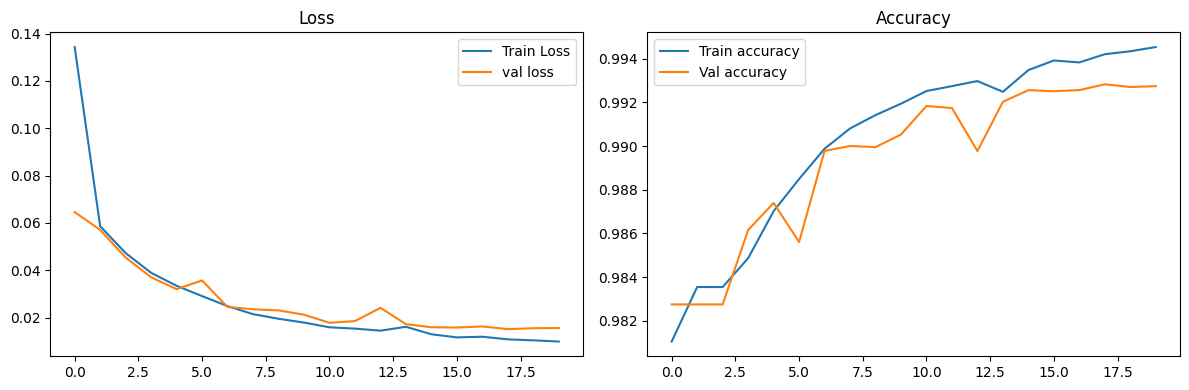

In [15]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label="val loss")
plt.title('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train accuracy')
plt.plot(history.history['val_accuracy'], label='Val accuracy')
plt.title('Accuracy')
plt.legend()

plt.tight_layout()
plt.show()

### 5. Model Evaluation

In [16]:
val_loss, val_acc, val_iou= model.evaluate(X_val, y_val)
print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_acc:.4f}")
print(f"Validation Mean IOU: {val_iou:.4f}")

18/18 ━━━━━━━━━━━━━━━━━━━━ 103s 5s/step - accuracy: 0.9924 - loss: 0.0165 - mean_io_u: 0.4927
Validation Loss: 0.0156
Validation Accuracy: 0.9927
Validation Mean IOU: 0.4928


In [17]:
y_pred = model.predict(X_val)

y_pred_thresh = (y_pred>0.5).astype(np.uint8)

18/18 ━━━━━━━━━━━━━━━━━━━━ 100s 5s/step


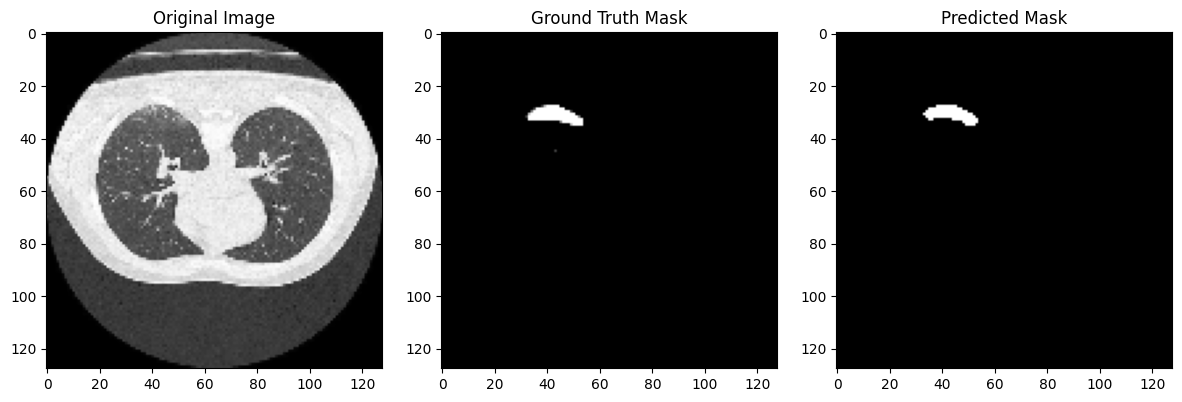

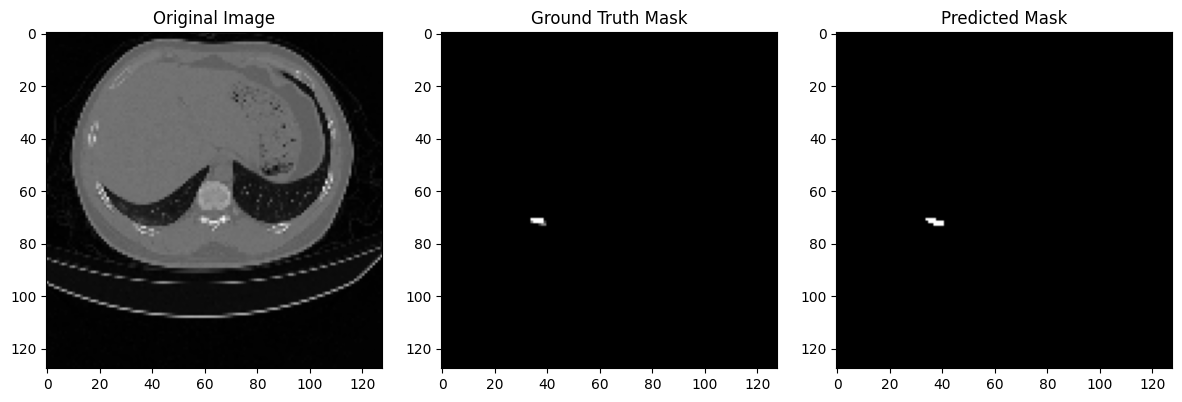

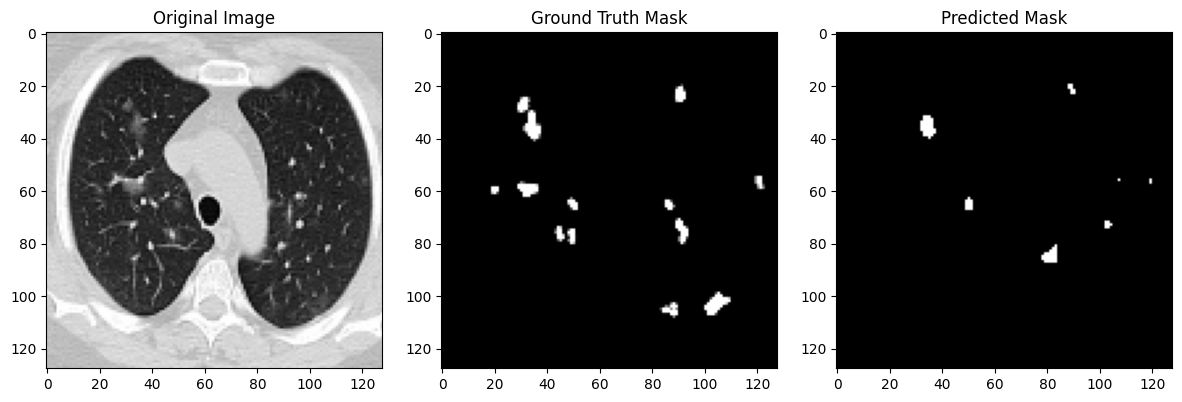

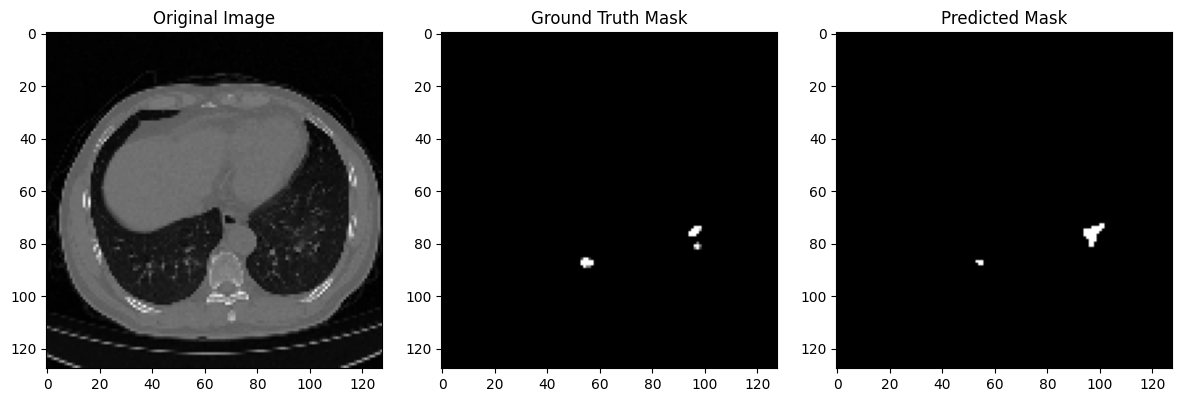

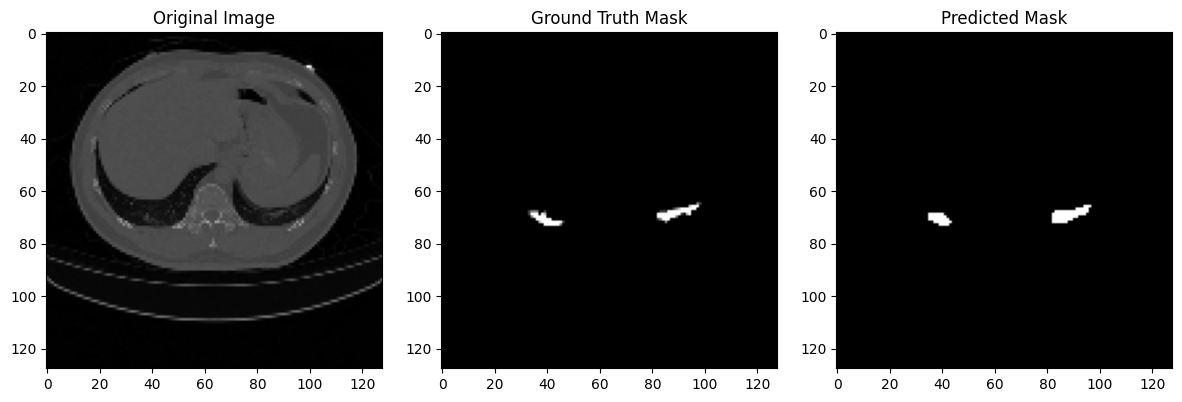

In [18]:
import random

num_smaples = 5
indices =  random.sample(range(len(X_val)), num_smaples)

for i in indices:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 3, 1)
    plt.title("Original Image")
    plt.imshow(X_val[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 2)
    plt.title("Ground Truth Mask")
    plt.imshow(y_val[i].squeeze(), cmap='gray')

    plt.subplot(1, 3, 3)
    plt.title("Predicted Mask")
    plt.imshow(y_pred_thresh[i].squeeze(), cmap='gray')

    plt.tight_layout()
    plt.show()

In [19]:
os.makedirs("predicted_masks", exist_ok=True)

for i in range(len(y_pred_thresh)):
    mask = (y_pred_thresh[i]*255).squeeze().astype(np.uint8)
    cv2.imwrite(f"predicted_masks/mask_{i}.png", mask)

### 6. Dice score

In [20]:
def dice_score(y_true, y_pred, smooth=1e-6):
    y_true_f = y_true.flatten()
    y_pred_f = y_pred.flatten()
    intersection = np.sum(y_true_f*y_pred_f)
    return (2. * intersection + smooth)/ (np.sum(y_true_f) + np.sum(y_pred_f) + smooth)


In [22]:
dice_scores=[]

for i in range(len(y_val)):
    score= dice_score(y_val[i], y_pred_thresh[i])
    dice_scores.append(score)

mean_dice = np.mean(dice_scores)
print(f"Mean Dice Score on Validation Set: {mean_dice:.4f}")

Mean Dice Score on Validation Set: 0.6731
